# Visualización de los filtros de los ConvNets

Basado en el capítulo 5 del libro "Deep Learning with Python" de Francois Chollet, 2018 Manning

Otra manera de entender las representaciones aprendidas por las capas convolucionales es desplegar los patrones visuales a los que cada filtro responde.

Esto se puede hacer empezando por una imágen vacía inicial, que va a ser modificada a partir de ascenso de gradiente teniendo como criterio la mayor activación del filtro.

El proceso consiste en definir la función de pérdida que maximiza el valor de un filtro dado de una capa convolucional, y utilizar SGD para ajustar los valores de la imagen de entrada para que esta perdida sea maximizada.

Vamos a tomar la red VGG16 pre entrenada con Imagenet, y a analizar la activación de uno de los filtros de una de las capas convolucionales de su tercer bloque convolucional.

In [1]:
import keras

Using TensorFlow backend.


In [3]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet', include_top=False)

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

Definimos una función de perdida que maximize el output del filtro.

Escogemos específicamente el primer filtro (índice 0) de la primera capa covolucional del tercer bloque de convoluciones separados por capas de max pooling, y definimos la operación de la función de perdida correspondiente al promedio de los valores de los pixeles del filtro; loss va a ser entonces el tensor donde queda el resultado de pasar una imagen por la red y calcular el promedio de los pixeles del filtro en cusestión.

In [8]:
layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [9]:
loss

<tf.Tensor 'Mean_2:0' shape=() dtype=float32>

Vamos ahora a definir la operación que calcula los gradientes del loss con respecto al input. Utilizamos la función **gradients**, del módulo de *backend*; al igual que loss, grads es el resultado (en forma de tensor) de aplicar una función a un input de la red.

In [17]:
# Llamar a `gradients` retorna una lisa con los tensores (de tamaño 1 en este caso)
# Solo nos interesa el primer valor.
grads = K.gradients(loss, model.input)[0]

In [15]:
grads

<tf.Tensor 'gradients_2/block1_conv1_1/convolution_grad/Conv2DBackpropInput:0' shape=(?, ?, ?, 3) dtype=float32>

Un truco para que el proceso de gradient ascent se realice de la mejor manera, es normalizar el tensor del gradiente, dividiéndolo por su norma L2, para así asegurarnos que la magnitud de las actualizaciones hechas a la imágen de entrada este siempre bajo el mismo rango (igual a 1).

In [18]:
# Agregamos un epsilon de 1e-5 antes de dividir par evitar una división por 0.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

Ahora calculamos el valor de la función de pérdida y el tensor del gradiente, dada una imágen inicial con valores de pixeles en blanco (definimos un tensor de 150x150 con los 3 canales RGB todos con valores en 0).

Definimos una función de backend que llamamos ``iterate`` que para un tensor de entrada retorna una lista con dos tensores, uno con la pérdida, y otro con el gradiente, aplicando las funciones *loss* y *grads* ya definidas

In [19]:
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

Ahora si realizamos un ciclo de gradient ascent con 40 iteraciones, partiendo de una imagen RGB aleatoria, que se va a ir modificando a partir de los gradientes agregados.

In [20]:
# Empezamos con una imagen en escala de grises aleatoria
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# Itermos 40 pasos en un proceso de gradient ascent
step = 1.  # Learning rate
for i in range(40):
    # Calculamos los valores del loss y del gradiente
    loss_value, grads_value = iterate([input_img_data])
    # Modificamos la imagen en la direccion que maximiza el gradiente del loss
    input_img_data += grads_value * step

Normalizamos los valores de los canales RGB y escalamos asegurandonos que todos los valores estén entre 0 y 255.

In [21]:
def deprocess_image(x):
    # Normalizamos el tensor: centro en 0., std es 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # Nos aseguramos que todos los valores están en [0, 1] (clipping)
    x += 0.5
    x = np.clip(x, 0, 1)

    # Convertimos a un array RGB para que sea visible
    x *= 255
    x = np.clip(x, 0, 255).astype(int)
    return x

Creamos ahora una función genérica que recibe el nombre de una capa y el índice del filtro que se desea procesar y devuelve la imágen que maximiza el gradiente del filtro en cuestión.

In [22]:
def generate_pattern(layer_name, filter_index, size=150):
    # Crea una función de loss que maximiza la activación del n-avo filtro de la capa en cuestión
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Calcula el gradiente de la imagen de entrada con respecto al loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization del gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # Esta función retorn el loss y el gradiente dada la imagen de entrada
    iterate = K.function([model.input], [loss, grads])
    
    # Empezamos con una imagen gris con un poco de ruido
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # 40 iteraciones de gradient ascent
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

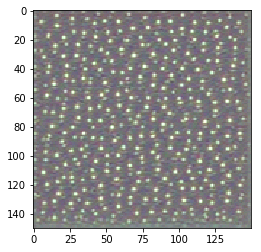

In [24]:
import matplotlib.pyplot as plt

im = generate_pattern('block3_conv1', 0)
plt.imshow(im)
plt.show()

Este filtro es receptivo a un patrón de puntos .

Vamos a visualizar los primeros 64 filtros de la primera capa convolucional de cada bloque del VGG (cada bloque tiene 2 Conv2D seguidos de un MaxPooling2D), mostrándolos como regiones de 64x64 dentro de una sola gran imagen por capa. cada imagen va a presentar los 64 filtros de una misma capa organizados en 8 filas de a 8 imágenes.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


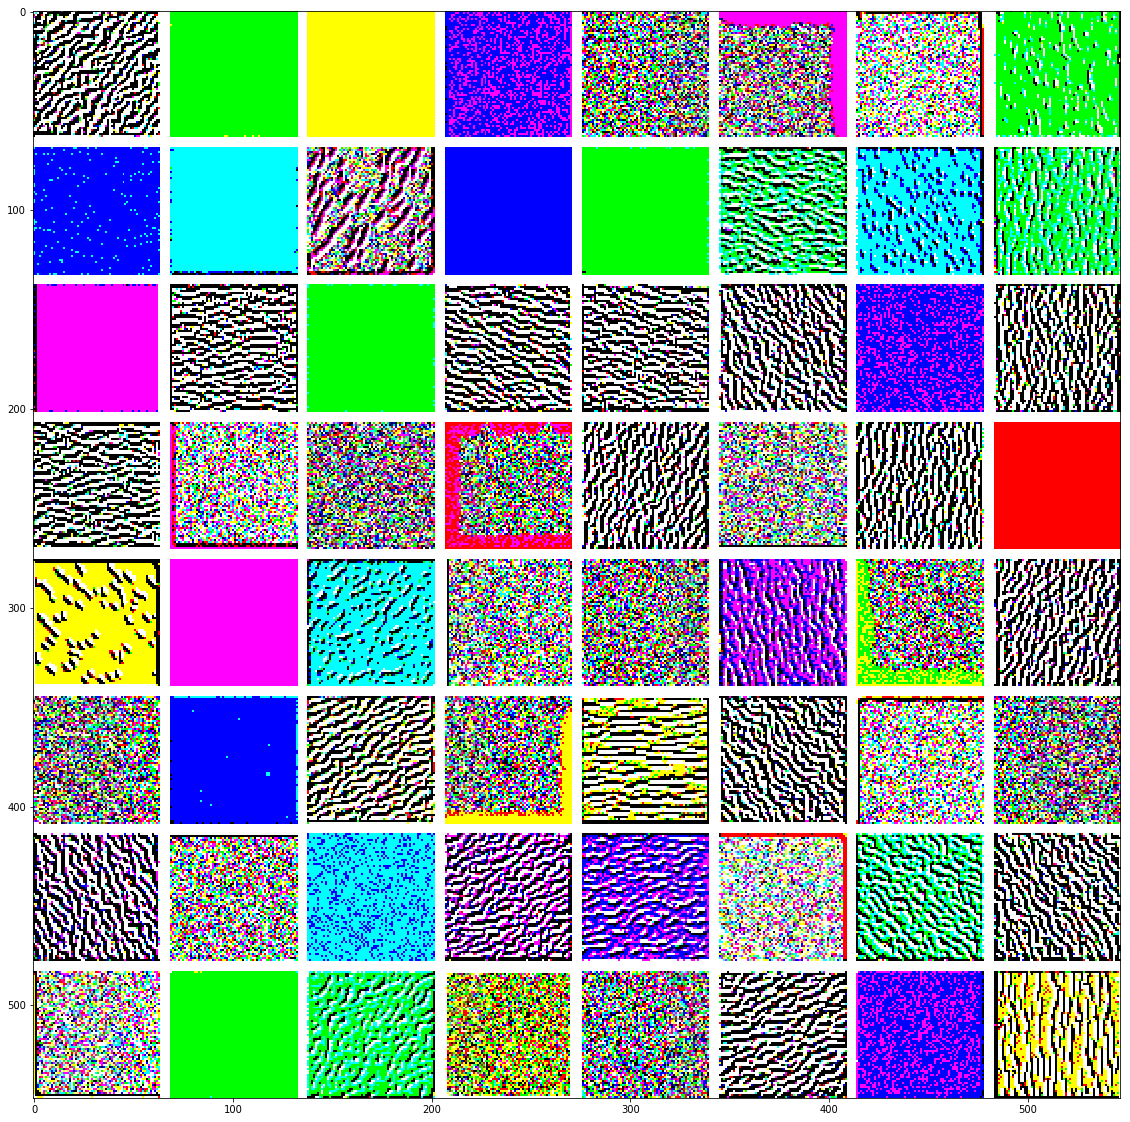

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


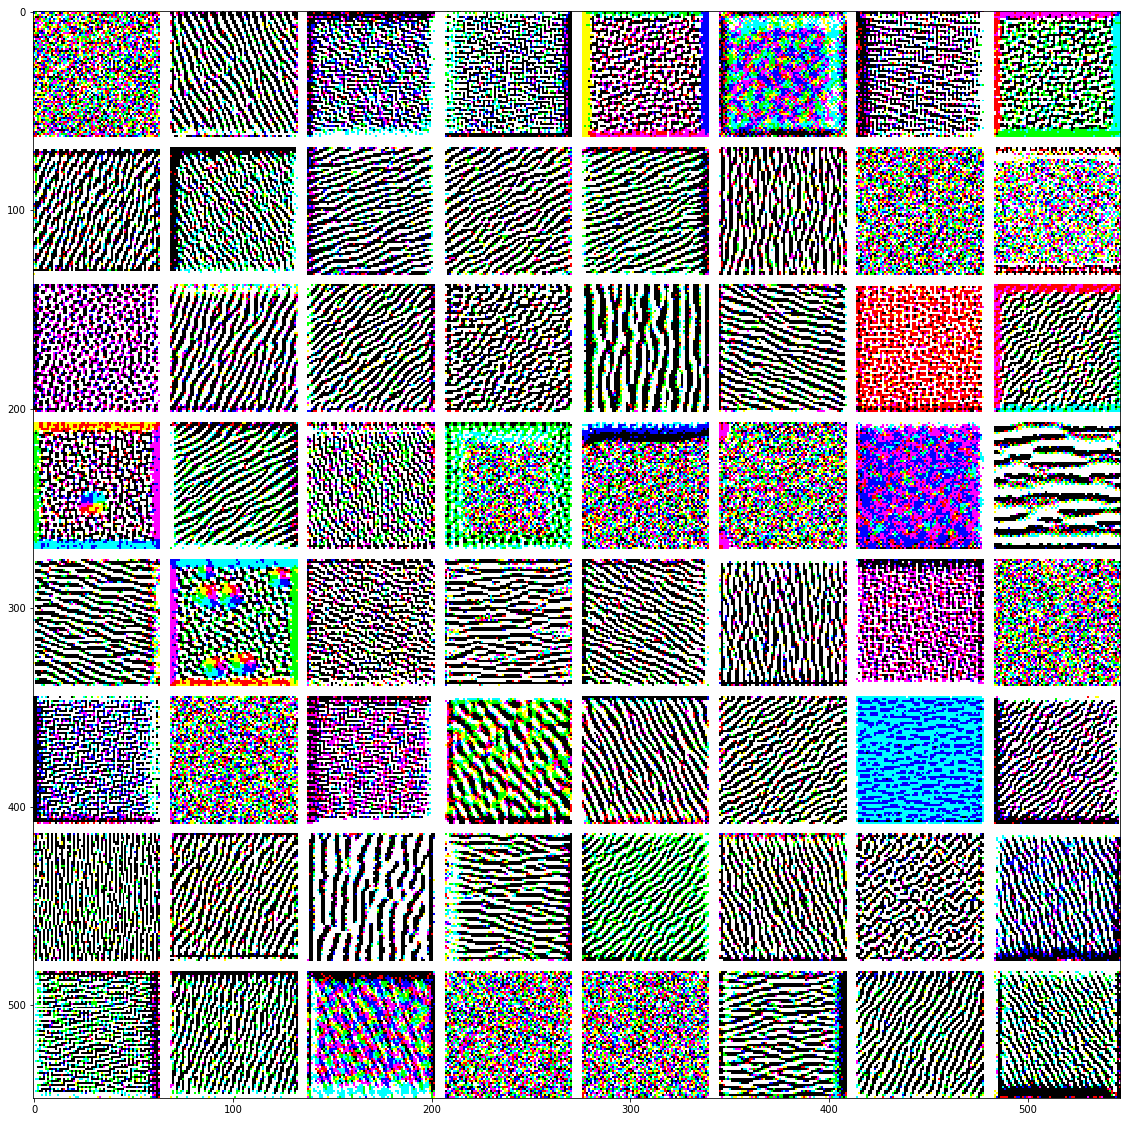

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


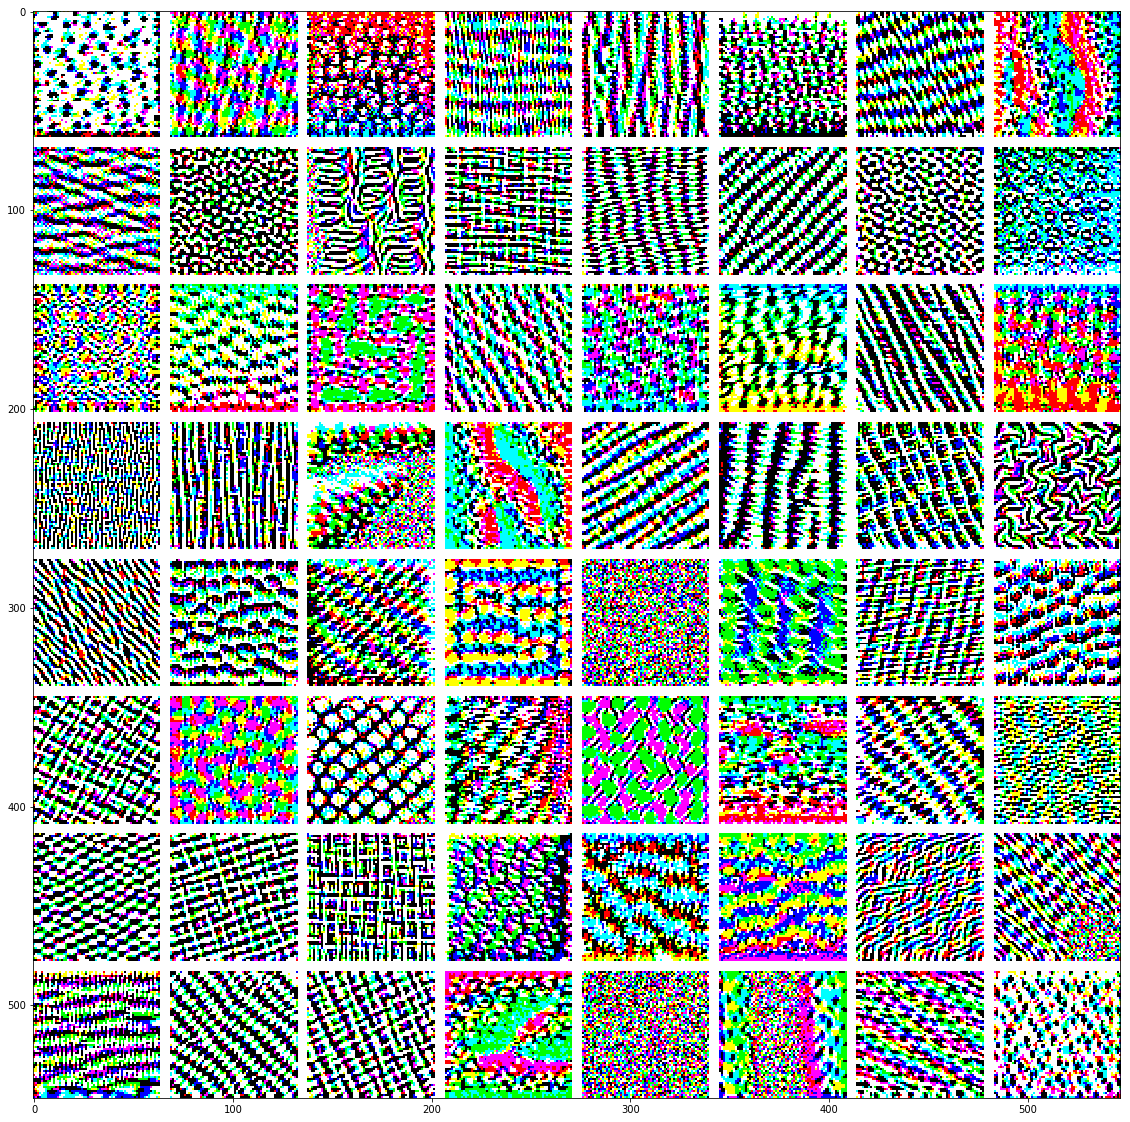

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


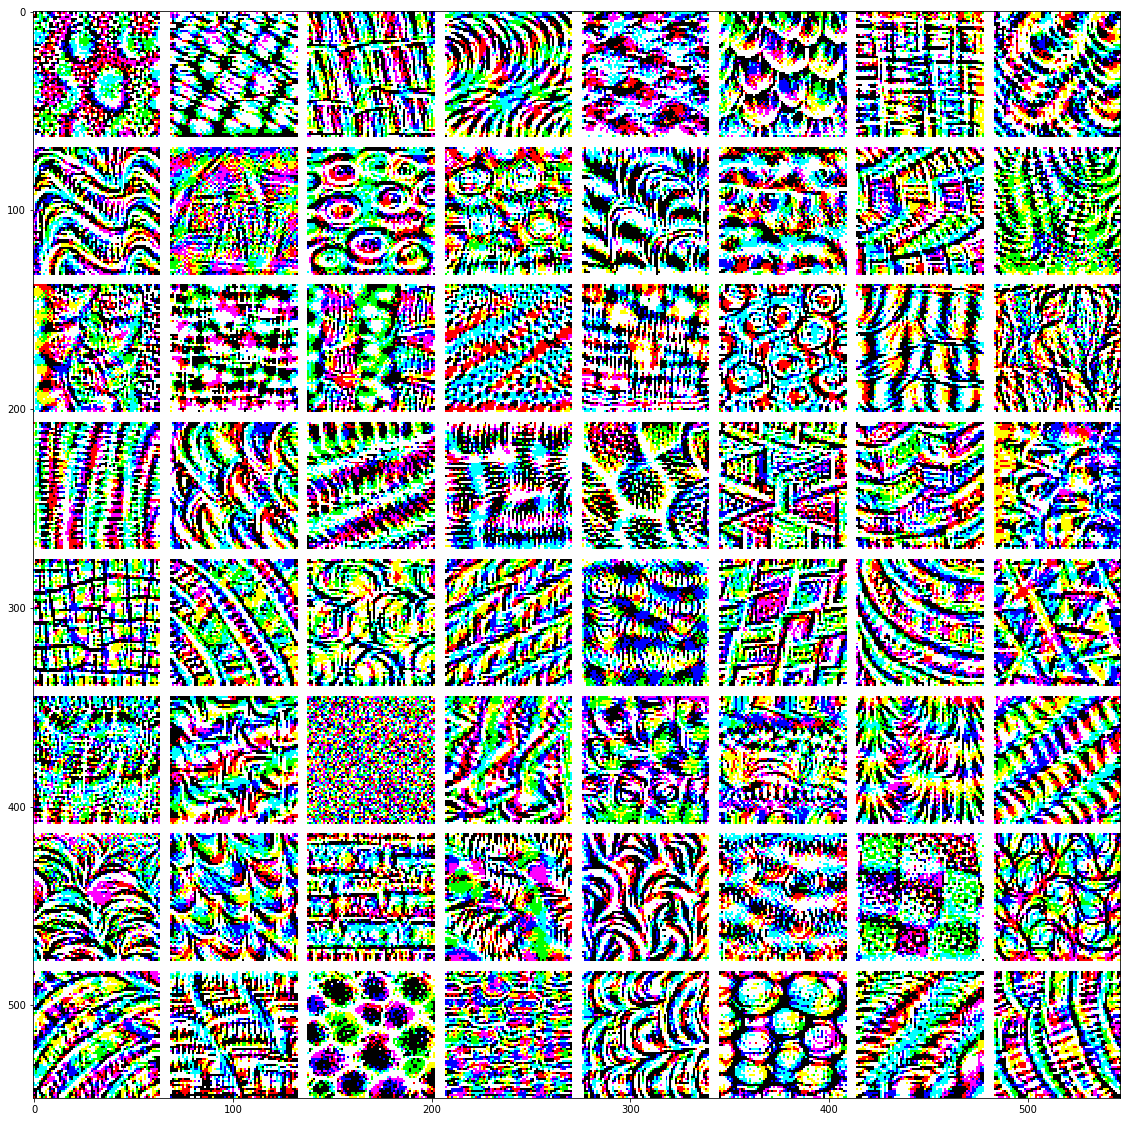

In [25]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5
    numrows = 8
    numcols = 8

    # Imagen vacía (negra) donde quedarán los resultados.
    results = np.zeros((numrows * size + (numrows-1) * margin, numcols * size + (numrows-1) * margin, 3), np.int8)

    for i in range(numrows):  # iterar las filas de los resultados
        for j in range(numcols):  # iterate las columnas de los resultados
            # Generar un patrón para el filtro de la fila*columna correspondiente de la capa actual
            filter_img = generate_pattern(layer_name, i + (j * numcols), size=size)

            # Poner el resultado en el cuadrado en la posición `(i, j)` de la imagen con todos los resultados
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

Se puede ver como a medida que los filtros pertenecen a capas cada vez mas alejadas de los inputs, los patrones son cada vez mas complejos, ya que se trata de patrones formados por combinación de los filtros de las capas precedentes.
Los de la capa `block1_conv1` codifican simples bordes direccionales y colores; los de la capa `block2_conv1` codifican texturas simples que combinan bordes y colores; los de la capa `block3_conv1` se parecen a texturas que se pueden encontrar en imágenes de la naturaleza, como plumas, hojas, ojos, etc.